# Import libraries and dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

In [2]:
df = pd.read_csv(r"C:\Users\Cris\Documents\Repos\TitanicML\titanic_train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Drop Passenger ID since it is redundant
df.drop(columns=["PassengerId"], inplace=True)

# Exploratory Data Analysis

In [4]:
# Check details of our dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


## Missing Values

In [5]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

It appears that there are 2 missing values for Embarked, 177 missing values for Age, and an important 687 null values in the Cabin column. We shall deal with these situations the following ways per column.

### Embarked

In [6]:
df[df.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Since there are only two missing rows for this category, it seems reasonable to simply drop these values, since the loss of information would be negligible. However, we could predict the two missing values with a simulation based on the probability of embarking on each port.

In [7]:
embarked_probs = df.Embarked[df.Embarked.notna()].value_counts()
print(embarked_probs/embarked_probs.sum())

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64


So, given the distribution of port occurrence, one shall assign the probability of embarking in a given port with those proportions. Therefore the simulation yields

In [8]:
import random

embarked_simulation = random.choices(population=embarked_probs.index.to_list(), weights=embarked_probs.to_list(), k=2)
print(embarked_simulation)

['Q', 'S']


In [9]:
df.Embarked.fillna(pd.Series(embarked_simulation, index=df[df.Embarked.isna()].index), inplace=True)

In [10]:
df[df.Cabin == "B28"]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,Q
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


### Cabin

In [11]:
df.Cabin.fillna("U", inplace=True)

In [12]:
df.Cabin.isna().sum()

0

In [13]:
df.Cabin.value_counts().head()

U              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
Name: Cabin, dtype: int64

### Age

In [14]:
df.Age.isna().sum()

177

In [15]:
df[df.Age.isna()].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,U,Q
17,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,U,S
19,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,U,C
26,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,U,C
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,U,Q


In [102]:
df.Age.describe()

<bound method NDFrame._add_numeric_operations.<locals>.mean of count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64>

Age follows a normal distribution according to the Shapiro-Wilk normality test, for which one can random sample the age from a normal distribution using NumPy.

In [111]:
age.mean()

29.69911764705882

In [136]:
age = df.Age[df.Age.notna()]

age_null = df.Age.isna().sum()

age_random_sample = np.random.normal(loc=age.mean(), scale=age.std(), size=age_null).round().astype(int)
print(age_random_sample.min())

-8


Problem, random sample has negative values >:(

<AxesSubplot: ylabel='Count'>

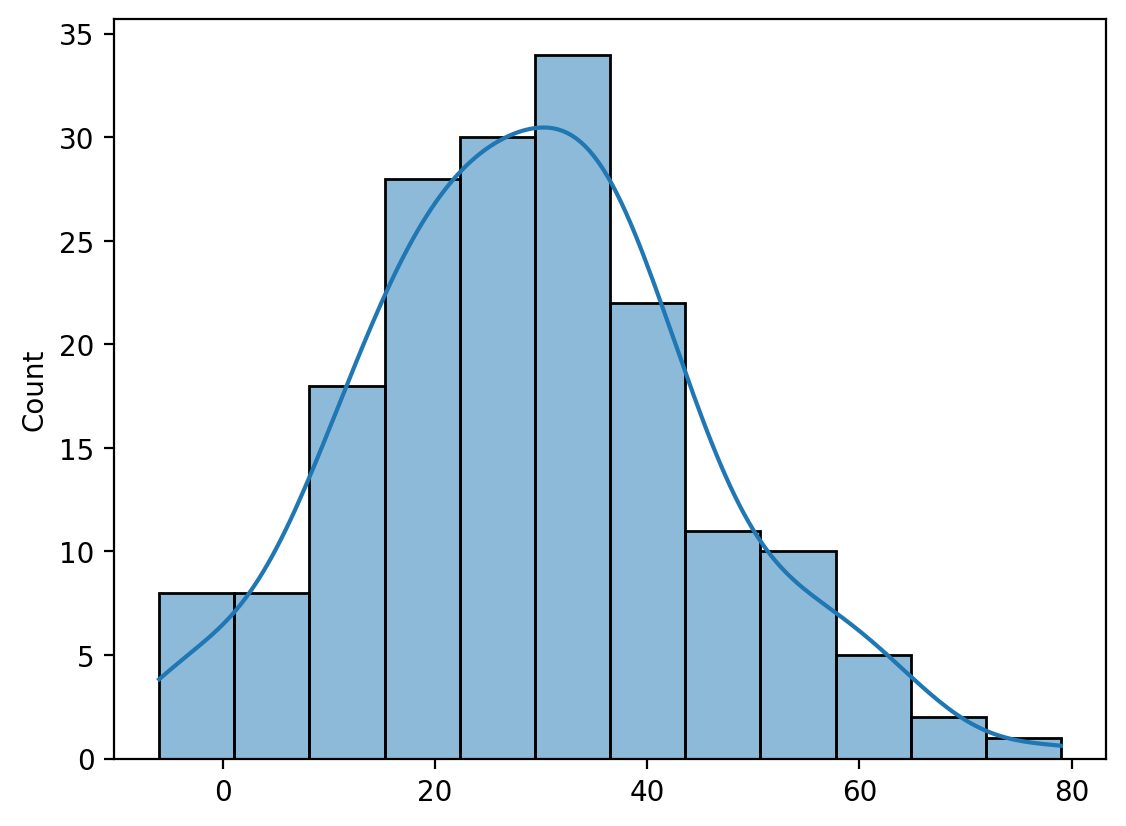

In [135]:
sns.histplot(age_random_sample, kde=True)

# ORGANIZE THIS LATER

In [36]:
# # Turn sex into one-hot, 1 is female, 0 is male
# df["Sex"] = pd.get_dummies(df.Sex)["female"]
# df.head()

In [37]:
# df.describe()

In [38]:
# df.info()

## Age

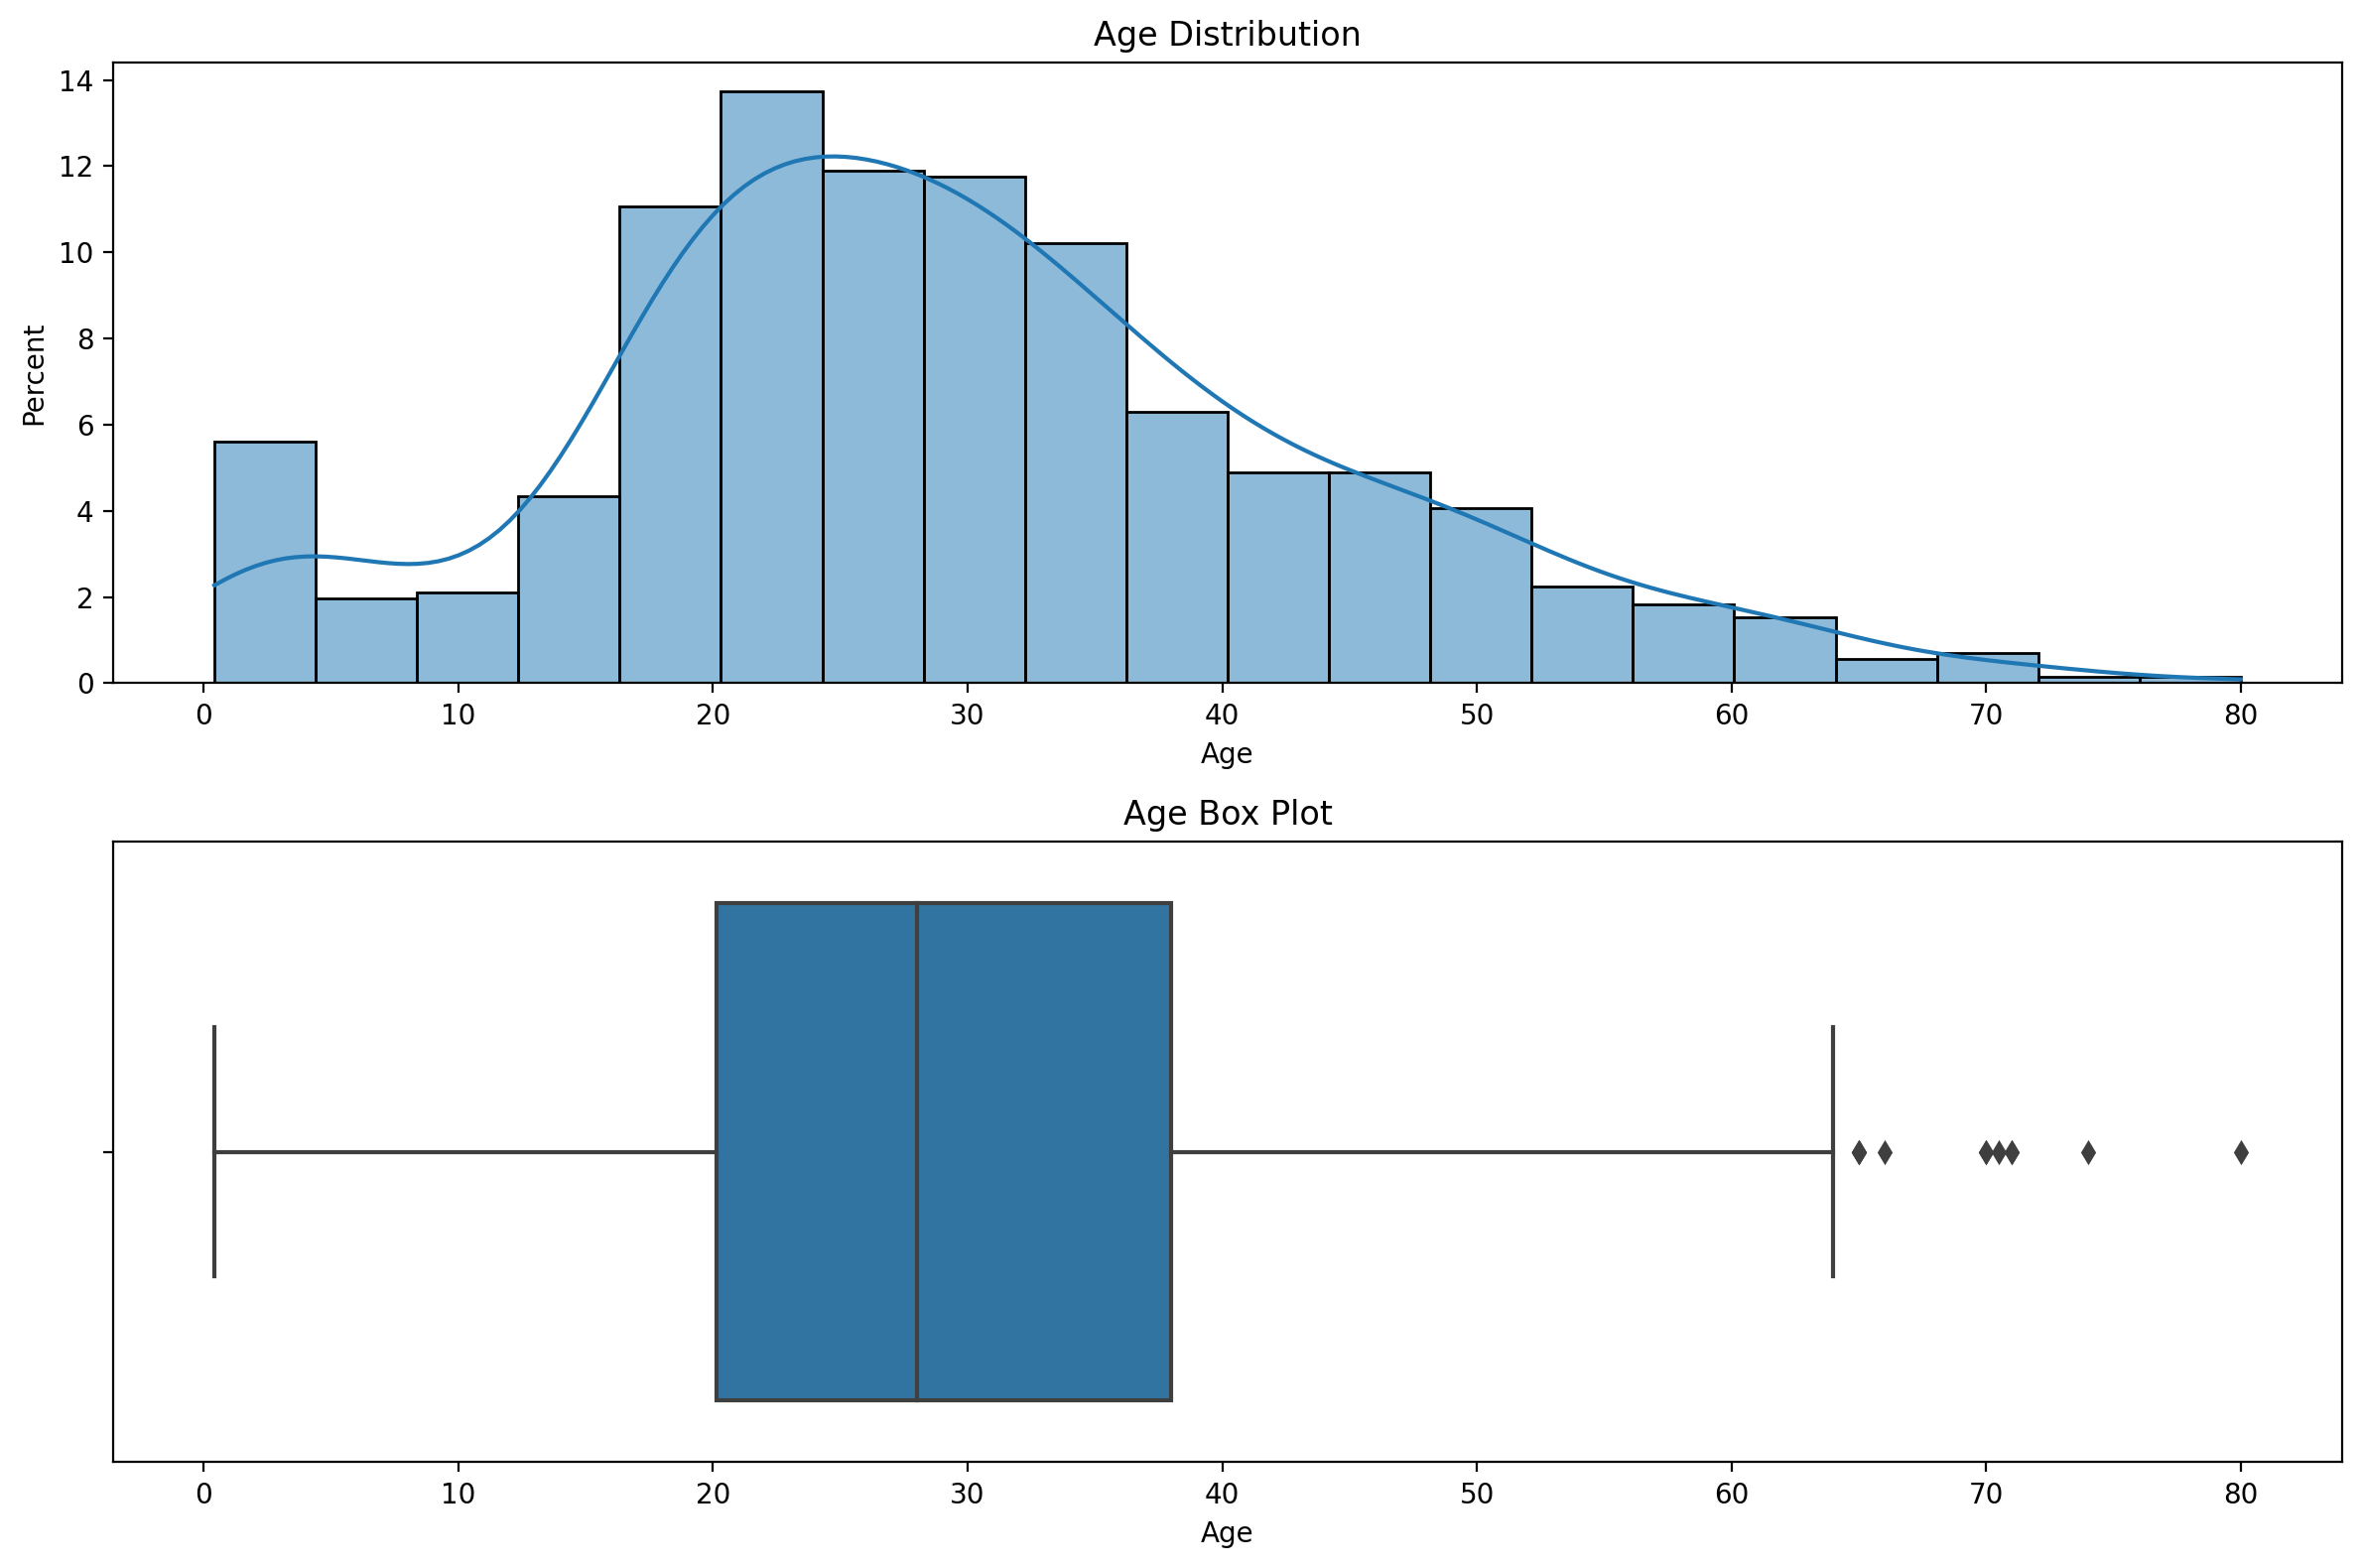

In [100]:
fig, axes = plt.subplots(2, figsize=(12,8))

sns.histplot(df.Age, kde=True, stat="percent", ax = axes[0])
axes[0].set_title("Age Distribution")

sns.boxplot(x=df.Age, ax=axes[1])
axes[1].set_title("Age Box Plot")

plt.tight_layout()
plt.show()

In [40]:
# fig, axes = plt.subplots(1,2, figsize=(16,8))

# sns.boxplot(data=df, x="Sex", y="Age", hue="Pclass", ax=axes[0])
# axes[0].set_xticks(ticks=[0, 1], labels=["Male", "Female"])
# axes[0].set_title("Age Boxplot by Sex and Ticket Class")

# sns.boxplot(data=df, x="Pclass", y="Age", hue="Sex", ax=axes[1])
# axes[1].set_title("Age Boxplot by Ticket Class and Sex")

# plt.show()

From this boxplot comparison it becomes evident that the class has a greater influence on age than sex. This makes sense since as you grow old you can make more money to purchase a more expensive ticket in a higher class.

## Fare

In [41]:
# fig, axes = plt.subplots(2, figsize=(12,8))

# sns.histplot(data=df, x="Fare", kde=True, stat="percent", color="green", ax = axes[0])
# axes[0].set_title("Fare Distribution")

# sns.boxplot(data=df, x="Fare", color="green", ax=axes[1])
# axes[1].set_title("Fare Box Plot")

# plt.tight_layout()
# plt.show()

In [42]:
# fig, ax = plt.subplots()
# sns.boxplot(data=df, x="Pclass", y="Fare")
# ax.semilogy()
# plt.title("Fare by Ticket Class")
# plt.show()

## Null values handling

In [43]:
# df.Age.fillna(df.Age.mean, inplace=True)

## Feature Extraction

In [44]:
# # Lone travelers
# alone = (df.SibSp < 1) & (df.Parch < 1)
# df["Alone"] = alone.astype(int)

In [45]:
# # Ticket Class
# df[["Class1", "Class2", "Class3"]] = pd.get_dummies(df.Pclass)

In [46]:
# # Embarking place
# df[["Cherbourg", "Queenstown", "Southampton"]] = pd.get_dummies(df.Embarked)
# # df.drop(columns=["Embarked", "Pclass"], inplace=True)

## Cabins and Classes

In [47]:
# cabin = df[df.Cabin.notna()].dropna()

# decks = ["A", "B", "C", "D", "E"]
# for d in decks:
#     titanic_class = cabin.Cabin.str.contains(d).astype(int)
#     cabin["Deck_"+d] = titanic_class

# cabin.sum(numeric_only=True)

In [48]:
# fig, ax = plt.subplots(figsize=(14,8))
# sns.heatmap(cabin.corr(numeric_only=True), annot=True)
# plt.show()

In [49]:
# for i,d in enumerate(decks):
#     titanic_class = first_class_cabin.str.contains(d).astype(int)
#     first_class_cabin[[d]] = titanic_class

In [50]:
# Feature extraction idea: family divisions? Lone travelers?
# df[df.Name.str.contains("Palsson")]
# df[(df.SibSp < 2) & (df.Parch > 2)]

# Travel alone category
# Parent, number of children
# Child, number of siblings